# Analysis of (Conditional) Mutual Information Estimators Using Forests - Sample Efficiency

In this simulation notebook, we will evaluate the sample efficiency of using forests to estimate
(conditional) mutual information. We will replicate the findings of https://arxiv.org/pdf/2110.13883.pdf. 

The data we will simulate comes from the following distributions for mutual information:

- Helix: X is dependent on Y on a helix
- Sphere: X is dependent on Y
- Uniform: X is dependent on Y
- Gaussian: X is dependent on Y
- independent: X is completely independent of Y

The data we will simulate comes from the following distributions for conditional mutual information:

- Uniform: X is conditionally dependent on Y
- Gaussian: X is conditionally dependent on Y

For each distribution, we will add a varying number of independent dimensions to the data (i.e. sampled from Gaussian distribution).

In [142]:
import numpy as np
import scipy
import scipy.spatial

from sklearn.neighbors import NearestNeighbors
import treeple
from treeple.experimental.simulate import (simulate_helix, simulate_multivariate_gaussian, simulate_sphere)
from treeple.experimental.mutual_info import (
    entropy_gaussian, entropy_weibull,
    cmi_from_entropy,
    mi_from_entropy,
    mutual_info_ksg,
    mi_gaussian, cmi_gaussian,
    mi_gamma, 
)
from treeple.tree import compute_forest_similarity_matrix
from treeple import UnsupervisedRandomForest, UnsupervisedObliqueRandomForest, ObliqueRandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Hyperparameters of the Simulation

In [4]:
seed =12345
rng = np.random.default_rng(seed)

In [125]:
n_jobs = -1

# hyperparameters of the simulation
n_samples = 500
n_noise_dims = 10
alpha = 0.01

# dimensionality of mvg
d = 3

# for sphere
radius = 1.0

# for helix
radius_a = 0.0
radius_b = 2.0

# manifold parameters
radii_func = lambda: rng.uniform(0, 1)

## Demonstrate a single simulation

Now, to demonstrate what the data would look like fromm a single parameterized simulation, we want to show the entire workflow from data generation to analysis and output value.

In [139]:
# generate helix data
helix_data = simulate_helix(radius_a=radius_a, radius_b=radius_b, alpha=alpha/2, n_samples=n_samples, return_mi_lb=True, random_seed=seed)
P, X, Y, Z, helix_lb = helix_data

# generate sphere data
sphere_data = simulate_sphere(radius=radius, alpha=alpha, n_samples=n_samples, return_mi_lb=True, random_seed=seed)
lat, lon, Y1, Y2, Y3, lb = sphere_data

# simulate multivariate Gaussian
mvg_data = simulate_multivariate_gaussian(d=d, n_samples=n_samples, seed=seed)
data, mean, cov = mvg_data

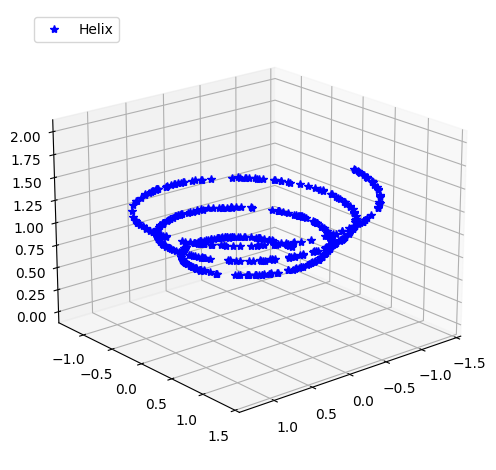

In [124]:
# helix data
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

ax1.plot( X, Y, Z, '*', c='b', label='Helix')
ax1.legend(loc='upper left');
ax1.axis('equal')
# ax1.set(
#     xlim=[-1, 1],
#     ylim=[-1, 1],
#     zlim=[0.25, 1],
# )
fig.tight_layout()
elev = 20
azim = 50
roll = 0
ax1.view_init(elev, azim, roll)

plt.show()


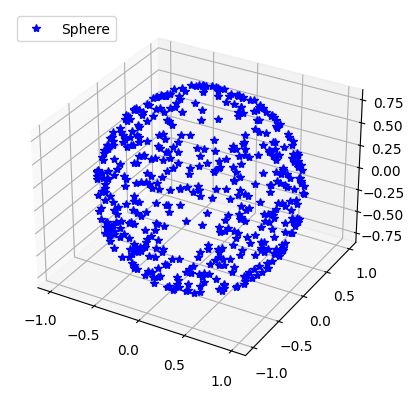

In [100]:
# sphere data
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

ax1.plot( Y1, Y2, Y3, '*', c='b', label='Sphere')
ax1.legend(loc='upper left');
ax1.axis('equal')

plt.show()


In [140]:
print(cov)
print(np.linalg.eigvals(cov))

[[ 0.31087872  0.01905156 -0.19413813]
 [ 0.01905156  1.21114085  2.27200637]
 [-0.19413813  2.27200637  5.13099624]]
[6.17646933 0.35752001 0.11902648]


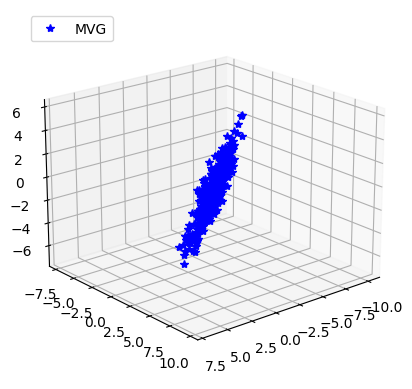

In [141]:
# mvg data
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

ax1.plot(data[:, 0], data[:, 1], data[:, 2], '*', c='b', label='MVG')
ax1.legend(loc='upper left');
ax1.axis('equal')
elev = 20
azim = 50
roll = 0
ax1.view_init(elev, azim, roll)

plt.show()


In [11]:
# fit an unsupervised forest
unsup_rf = Un

In [12]:
print(X.shape)
print(indices.shape, dists.shape)

(30, 2)
(30, 2) (30, 2)


In [13]:
print(dists[:5, :])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [68]:
X = np.arange(9).reshape((3, -1))
X = 0.5 * (X + X.T)
X = X / np.max(X)
X[np.diag_indices_from(X)] = 0.0
print(X)

print(np.triu(X, 1))

[[0.   0.25 0.5 ]
 [0.25 0.   0.75]
 [0.5  0.75 0.  ]]
[[0.   0.25 0.5 ]
 [0.   0.   0.75]
 [0.   0.   0.  ]]


In [69]:

nbrs = NearestNeighbors(
            n_neighbors=3, metric="precomputed", n_jobs=n_jobs
        ).fit(X)

# then get the K nearest nbrs in the Z space
dists, indices = nbrs.kneighbors(X)

print(dists.shape, indices.shape)
print(indices)
print(dists)

(3, 3) (3, 3)
[[0 1 2]
 [1 0 2]
 [2 0 1]]
[[0.   0.25 0.5 ]
 [0.   0.25 0.75]
 [0.   0.5  0.75]]


In [38]:
# get the triu indices
triu_idx = np.triu_indices_from(X, 1)

print(triu_idx)
print(X[triu_idx])



(array([1, 2, 2]), array([0, 0, 1]))
[3 6 7]


In [48]:
# get the triu indices
triu_idx = np.triu_indices_from(X, 1)

triu_ravel_argsort_idx = np.argsort(X[triu_idx], axis=None)

triu_argsort_idx = np.vstack(triu_idx).T[triu_ravel_argsort_idx].squeeze()

print(triu_argsort_idx)
print(X[triu_argsort_idx[:, 0], triu_argsort_idx[:, 1]])
# print(ravel_argsort_idx)

[[0 1]
 [0 2]
 [1 2]]
[1 2 5]


In [37]:
print(np.unravel_index(ravel_argsort_idx, (3, 3)))

(array([0, 0, 0]), array([0, 1, 2]))


In [34]:
argsort_idx = np.unravel_index(ravel_argsort_idx, (3, 3))

print(ravel_argsort_idx)
print(np.vstack(argsort_idx).T)

[0 1 2]
[[0 0]
 [0 1]
 [0 2]]


# Final Analysis Across All Possible Parametrizations

Now, we want to analyze Unsup-Forest-KSG, Sup-Forest-KSG, Uncertainty-Forest, and KSG-estimator for MI. Moreover, we can implement all traditional RF and oblique RF.